<a href="https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/12_Experiment_tracking_with_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

# Purpose 😇

This brief notebook will demonstrate how you can easily track your experiments using Weights & Biases (W&B).

You can find much more information on the W&B [Experiment tracking](https://docs.wandb.ai/guides/track) page.

# Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
# !pip install wandb -U >> /dev/null

In [ ]:
from tsai.all import *
from fastai.callback.wandb import *
import wandb
my_setup(wandb)

os             : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.12
tsai           : 0.2.23
fastai         : 2.5.2
fastcore       : 1.3.26
wandb          : 0.12.2
torch          : 1.9.0+cu102
n_cpus         : 2
device         : cuda (Tesla T4)


# Login to W&B 🔎

In [ ]:
wandb.login()

wandb: Currently logged in as: timeseriesai (use `wandb login --relogin` to force relogin)


True

# Create a configurable training script 🏋️‍♂️

In this notebook we'll run experiments with TSiT which is a new model developed by timeseriesAI inspired by ViT.

We'll first define a baseline we'll then try to improve: 

epoch,train_loss,valid_loss,accuracy,time
0,2.080252,1.576666,0.521087,00:01
1,1.614804,1.256952,0.591646,00:01
2,1.358594,1.146953,0.618410,00:01
3,1.193168,1.260768,0.563260,00:01
4,1.088524,1.090860,0.642741,00:01
5,0.979203,1.072997,0.641525,00:01
6,0.880059,0.974234,0.680049,00:01
7,0.788186,1.006785,0.666667,00:01
8,0.706335,0.917137,0.704380,00:01
9,0.656883,0.916646,0.705596,00:01


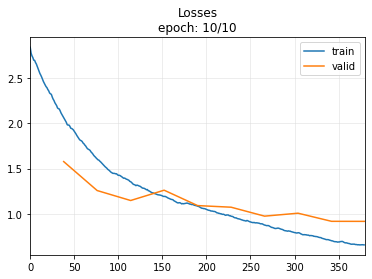

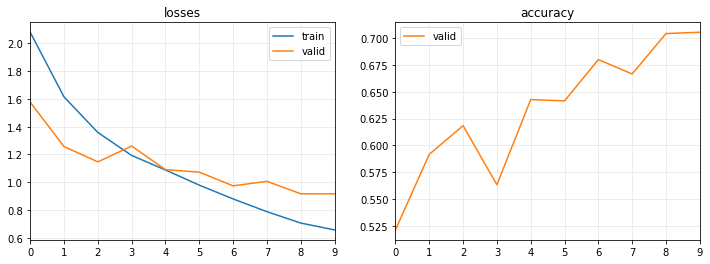

In [ ]:
X, y, splits = get_UCR_data('LSST', split_data=False)
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
cbs = [ShowGraph()] 
learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, arch=TSiTPlus, arch_config={}, metrics=accuracy, cbs=cbs)
learn.fit_one_cycle(10, 1e-3)

We'll now define which elements we'd like to test. These will be part of the config. 

Later we'll be able to modify the training script or the config.

epoch,train_loss,valid_loss,accuracy,time
0,2.078094,1.588653,0.523114,00:01
1,1.612723,1.249077,0.600162,00:01
2,1.351654,1.232383,0.592052,00:01
3,1.199912,1.073855,0.655312,00:01
4,1.083166,1.046569,0.675182,00:01
5,0.974308,0.995019,0.678021,00:01
6,0.868292,0.999589,0.682887,00:01
7,0.781063,0.928972,0.702757,00:01
8,0.716529,0.922481,0.703569,00:01
9,0.657766,0.915174,0.706407,00:01


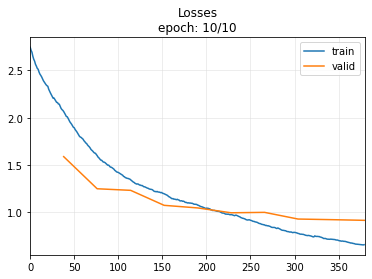

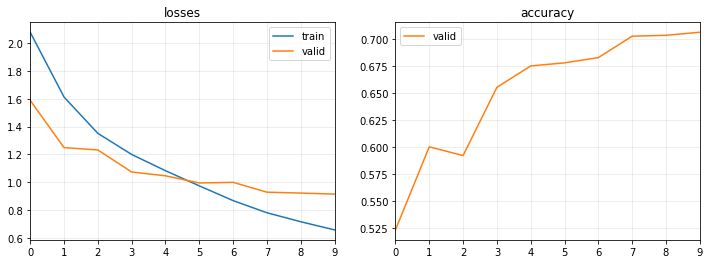

In [ ]:
config = AttrDict (
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = TSiTPlus,
    lr = 1e-3,
    n_epoch = 10,   
)

X, y, splits = get_UCR_data('LSST', split_data=False)
tfms = [None, TSClassification()]
cbs = [ShowGraph()] 
learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=config["batch_tfms"], arch=config["architecture"], 
                     arch_config=config["arch_config"], metrics=accuracy, cbs=cbs)
learn.fit_one_cycle(config["n_epoch"], config["lr"])

# Perform experiments with W&B 🛫

We just need to add 2 elements to have a configurable training script that can be tracked by W&B: 

- A context manager: 

    ```
    with wandb.init(project="LSST_v01", reinit=True, config=config):
    ```
    It may useful to pass a group, job type, tags, name, notes, etc. You can see the available options [here](https://docs.wandb.ai/ref/python/init).
- A callback: 

    ```
    WandbCallback()
    ```


⚠️ If you also want to save your best models, and set log_model=True in the WandbCallback, you'll need to add the SaveModelCallback as well.

There's currently a small bug in the integration between wandb and tsai that doesn't allow to log_preds. This can be used to show predictions in W&B. We recommend setting log_preds=False.

epoch,train_loss,valid_loss,accuracy,time
0,2.114535,1.589791,0.504461,00:01
1,1.632138,1.326617,0.592457,00:01
2,1.366500,1.315255,0.592052,00:01
3,1.198177,1.086082,0.643958,00:01
4,1.060263,1.011896,0.671533,00:01
5,0.946860,0.994727,0.680860,00:01
6,0.848480,0.985425,0.697080,00:01
7,0.757913,0.919544,0.710462,00:01
8,0.679247,0.905018,0.714517,00:01
9,0.623348,0.902409,0.714112,00:01


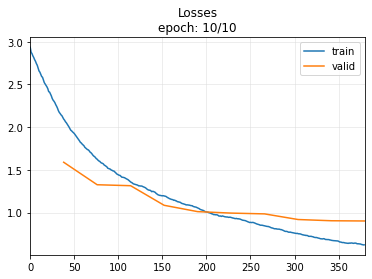

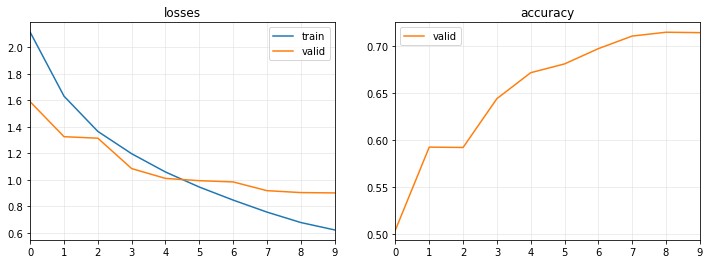

accuracy,0.71411
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.6759
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▄▄▆▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# YOU CAN MODIFY YOUR CONFIG AND/OR TRAINING SCRIPT IN THIS CELL AND RE-RUN MANUAL EXPERIMENTS THAT WILL BE TRACKED BY W&B

config = AttrDict (
    batch_tfms = TSStandardize(by_sample=True),
    arch = TSiTPlus,
    arch_config = {},
    lr = 1e-3,
    n_epoch = 10,   
)

with wandb.init(project="LSST_v01", config=config, name='baseline'):
    X, y, splits = get_UCR_data('LSST', split_data=False)
    tfms = [None, TSClassification()]
    cbs = [ShowGraph(), WandbCallback(log_preds=False, log_model=False, dataset_name='LSST')] 
    learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=config.batch_tfms, arch=config.arch, 
                         arch_config=config.arch_config, metrics=accuracy, cbs=cbs)
    learn.fit_one_cycle(config.n_epoch, config.lr)

# Visualize results 🕸

You will be able to see your experiment results in the W&B website.

The links are displayed with the run details like this: 

```
Project page: https://wandb.ai/timeseriesai/LSST_v01
Run page: https://wandb.ai/timeseriesai/LSST_v01/runs/34lacjyd
```

# How to test multiple values: use loops? 🌀

We can even run loops. In this case we'll test if adding a convolution/s with different kernel sizes improves performance. You'll be able to check progress in the W&B website during the test. That's why are remove the ShowGraph callback.

epoch,train_loss,valid_loss,accuracy,time
0,2.106912,1.585571,0.504866,00:01
1,1.616565,1.295642,0.560827,00:01
2,1.351119,1.182734,0.610300,00:01
3,1.188972,1.201490,0.617194,00:01
4,1.083488,1.102667,0.635848,00:01
5,0.984776,1.052097,0.656934,00:01
6,0.882159,1.037492,0.672749,00:01
7,0.791272,0.957581,0.692214,00:01
8,0.719182,0.919564,0.706407,00:01
9,0.664114,0.919914,0.708435,00:01


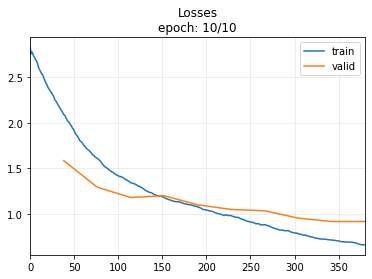

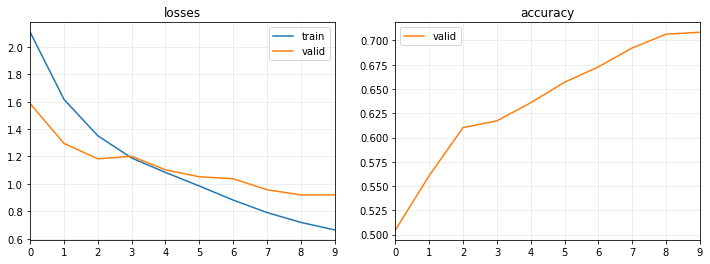

accuracy,0.70843
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.51405
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▃▅▅▆▆▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▆▃▄▄▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁▂▁▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.022336,1.529024,0.551906,00:01
1,1.544441,1.251528,0.596107,00:01
2,1.289575,1.127850,0.639092,00:01
3,1.146650,1.042489,0.644769,00:01
4,1.016892,1.053039,0.661395,00:01
5,0.918026,0.971166,0.685726,00:01
6,0.822939,0.915165,0.708029,00:01
7,0.729064,0.912994,0.706407,00:01
8,0.655014,0.896970,0.717356,00:01
9,0.595882,0.897511,0.716545,00:01


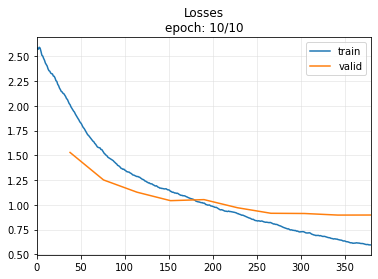

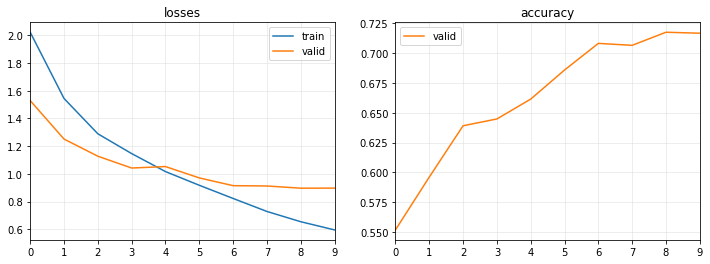

accuracy,0.71654
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.58872
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▃▅▅▆▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▆▄▄▄▄▃▃▄▃▄▂▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,1.983263,1.496564,0.548662,00:01
1,1.531047,1.495873,0.545418,00:01
2,1.287402,1.133325,0.651257,00:01
3,1.118862,1.234268,0.632603,00:01
4,0.996022,0.962171,0.699513,00:01
5,0.904068,0.976103,0.686131,00:01
6,0.807420,0.949470,0.701946,00:01
7,0.712814,0.915579,0.716139,00:01
8,0.632889,0.886929,0.718167,00:01
9,0.577995,0.878951,0.721006,00:01


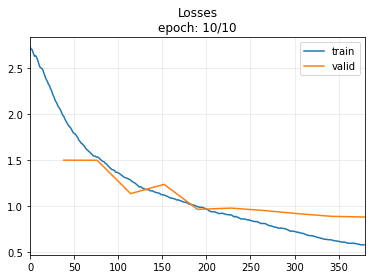

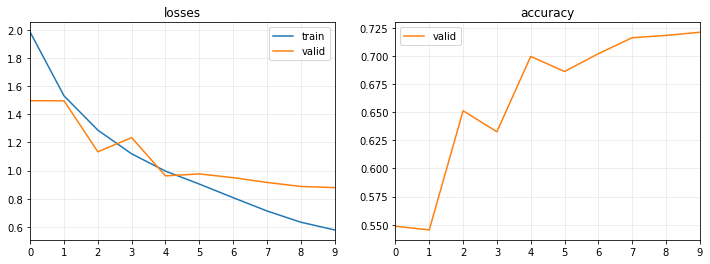

accuracy,0.72101
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.64854
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▁▅▄▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▄▅▅▄▃▄▄▃▂▂▃▃▃▃▃▃▃▂▃▃▂▂▂▃▁▂▁▂▁▂▂▂▂▁▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.046594,1.536608,0.533252,00:01
1,1.542286,1.280013,0.591241,00:01
2,1.277843,1.080615,0.650852,00:01
3,1.117956,1.014370,0.674371,00:01
4,0.996434,1.029199,0.665045,00:01
5,0.909742,1.091028,0.651663,00:01
6,0.812353,0.919863,0.706002,00:01
7,0.712129,0.898865,0.715734,00:01
8,0.628552,0.891999,0.720195,00:01
9,0.571681,0.885267,0.722628,00:01


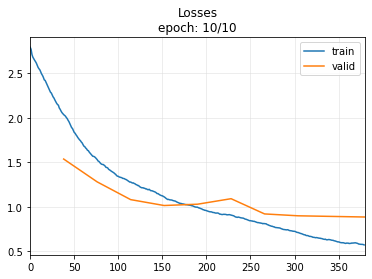

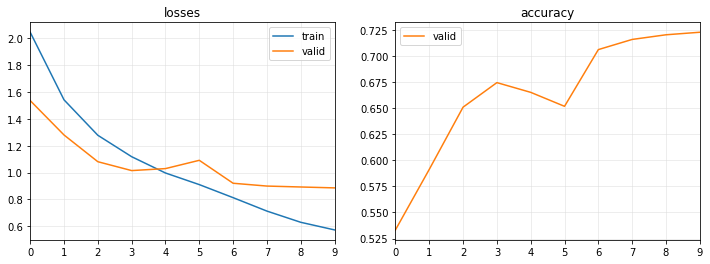

accuracy,0.72263
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.36249
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▃▅▆▆▅▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▆▆▅▄▃▃▄▃▄▃▃▄▂▂▃▃▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.029640,1.507968,0.541363,00:01
1,1.553599,1.197012,0.643147,00:01
2,1.285845,1.071525,0.645985,00:01
3,1.112243,1.060000,0.658151,00:01
4,0.974403,1.022519,0.687348,00:01
5,0.870751,0.996105,0.684104,00:01
6,0.758886,0.922510,0.705596,00:01
7,0.661384,0.914093,0.711679,00:01
8,0.569740,0.909809,0.714923,00:01
9,0.499877,0.908634,0.718167,00:01


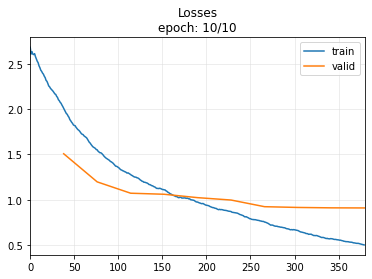

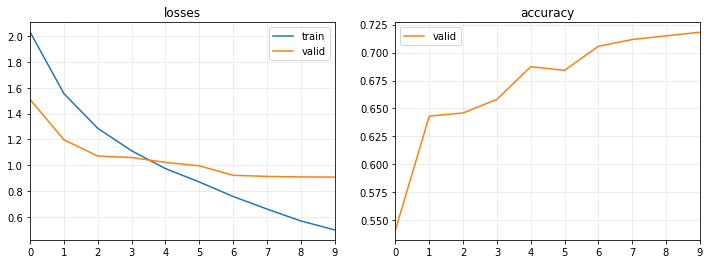

accuracy,0.71817
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.32325
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▅▅▆▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇▆▅▆▅▃▄▄▄▃▃▃▂▄▃▃▃▃▃▂▃▂▂▁▂▂▁▂▂▃▂▂▁▂▂▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.019165,1.515511,0.531225,00:01
1,1.543177,1.471329,0.552717,00:01
2,1.299206,1.239401,0.620032,00:01
3,1.119941,0.981235,0.681671,00:01
4,0.986218,0.982784,0.682887,00:01
5,0.882408,0.982510,0.683293,00:01
6,0.764272,0.917734,0.710057,00:01
7,0.659821,0.928926,0.706002,00:01
8,0.559555,0.889057,0.725872,00:01
9,0.490166,0.889080,0.724250,00:01


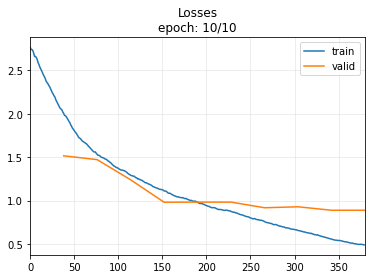

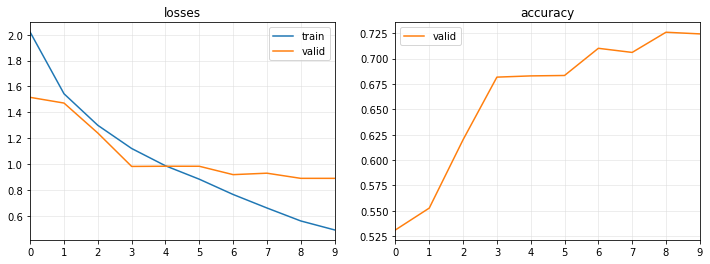

accuracy,0.72425
epoch,10
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.95
mom_1,0.95
raw_loss,0.36197
sqr_mom_0,0.99
sqr_mom_1,0.99


accuracy,▁▂▄▆▆▆▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▁▁▂▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
for ks in [None, 1, 3, 5, 7, [1, 3, 5, 7]]:

    config = AttrDict (
        batch_tfms = TSStandardize(by_sample=True),
        arch = TSiTPlus,
        arch_config = dict(ks=ks),
        lr = 1e-3,
        n_epoch = 10,   
    )

    with wandb.init(project="LSST_v01", config=config, group='kss'):
        X, y, splits = get_UCR_data('LSST', split_data=False)
        tfms = [None, TSClassification()]
        cbs = [ShowGraph(), WandbCallback(log_preds=False, log_model=False, dataset_name='LSST')] 
        learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=config.batch_tfms, arch=config.arch, 
                            arch_config=config.arch_config, metrics=accuracy, cbs=cbs)
        learn.fit_one_cycle(config.n_epoch, config.lr)

In this case we've learned that setting a ks parameter significantly improves performance. That's a great finding!

# Conclusion ✅

`wandb` is a great tool that allows you to easily track your experiments. 

It's super-flexible. It allows you to track your dataset, data preprocessing, data transforms, architecutres, architecture configurations, training loop, etc. 

And you can group runs in projects to easily compare them. 

Here's all the code you need to start running experiments with W&B and `tsai`: 

```
from tsai.all import *
from fastai.callback.wandb import *
import wandb

config = AttrDict (
    batch_tfms = TSStandardize(by_sample=True),
    arch = TSiTPlus,
    arch_config = {},
    lr = 1e-3,
    n_epoch = 10,   
)

with wandb.init(project="LSST_v01", config=config, name='baseline'):
    X, y, splits = get_UCR_data('LSST', split_data=False)
    tfms = [None, TSClassification()]
    cbs = [ShowGraph(), WandbCallback(log_preds=False, log_model=False, dataset_name='LSST')] 
    learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=config.batch_tfms, arch=config.arch, 
                         arch_config=config.arch_config, metrics=accuracy, cbs=cbs)
    learn.fit_one_cycle(config.n_epoch, config.lr)
```

We've seen here just a small amount of everything W&B has to offer. I hope you'll start benefiting from it!